In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_ops import ChromosomeOp, OperationBlock, CNN, Inputs



Using TensorFlow backend.


In [2]:
from utils.codification_ops import OperationBlock, ChromosomeOp, CNN, Identity, Sum, Inputs, MaxPooling
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, concatenate, Dropout
from keras.layers import MaxPooling2D as MP
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


def suma():
    return Sum()

def iden():
    return Identity()

def maxp():
    return MaxPooling()

def res_cnn(fm): 
    # filter mul = 1.12 makes the net double the number of filters every 6 convolutions.
    # That's because ResNet20 has 3 cells per block, and 2 convs on each cell. Therefore, it has 6 convs
    # block.
    return CNN(filter_mul=fm, kernel_size=3, activation='relu', dropout=0.)

def get_res_ops(fm=1.12):
    return [iden(), res_cnn(fm), maxp()]

##### ResNet V1 like Architecture

In [3]:
ChromosomeOp.N_BLOCKS = 3
ChromosomeOp.CELLS_PER_BLOCK = 3
ChromosomeOp.INITIAL_FILTERS = 16

op1 = OperationBlock(operation_type='CNN', ops=get_res_ops(), concatenation=suma(), inputs=Inputs(np.array([1])))
op2 = OperationBlock(operation_type='CNN', ops=get_res_ops(), concatenation=suma(), inputs=Inputs(np.array([0, 1])))
op3 = OperationBlock(operation_type='CNN', ops=get_res_ops(1.24), concatenation=suma(), inputs=Inputs(np.array([1,0,0])))
op4 = OperationBlock(operation_type='Identity', ops=get_res_ops(), concatenation=suma(), inputs=Inputs(np.array([0, 0, 1, 1])))
resnet_C = ChromosomeOp(blocks = [op1, op2, op3, op4], n_blocks = 4)



##### ResNet V1 Architecture

In [4]:
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2





def resnet_v1(input_shape, depth, num_classes=10, init=True, reg=True, drop=False):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    
    def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
        """2D Convolution-Batch Normalization-Activation stack builder

        # Arguments
            inputs (tensor): input tensor from input image or previous layer
            num_filters (int): Conv2D number of filters
            kernel_size (int): Conv2D square kernel dimensions
            strides (int): Conv2D square stride dimensions
            activation (string): activation name
            batch_normalization (bool): whether to include batch normalization
            conv_first (bool): conv-bn-activation (True) or
                bn-activation-conv (False)

        # Returns
            x (tensor): tensor as input to the next layer
        """
        initializer = 'he_normal' if init else 'glorot_uniform'
        regularizier = l2(1e-4) if reg else None
        conv = Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer=initializer,
                      kernel_regularizer=regularizier)

        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        if drop:
            x = Dropout(0.1)(x)
        return x


    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

class ResNet20():
    
    def __init__(self, init=True, reg=True, drop=False):
        self.init = init
        self.reg = reg
        self.drop = drop
    
    def decode(self, input_shape, num_classes, verb=True, fp=32):
        model = resnet_v1(input_shape, 20, num_classes=num_classes, init=self.init, reg=self.reg, drop=self.drop)
        if verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        return model


#### DenseNet

In [5]:
def densenet_builder(input_shape, num_classes=10):
    # start model definition
    # densenet CNNs (composite function) are made of BN-ReLU-Conv2D
    num_dense_blocks = 3
    growth_rate = 12
    depth = 100
    num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)
    data_augmentation = False
    num_filters_bef_dense_block = 2 * growth_rate
    compression_factor = 0.5

    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(num_filters_bef_dense_block,
               kernel_size=3,
               padding='same',
               kernel_initializer='he_normal')(x)
    x = concatenate([inputs, x])

    # stack of dense blocks bridged by transition layers
    for i in range(num_dense_blocks):
        # a dense block is a stack of bottleneck layers
        for j in range(num_bottleneck_layers):
            y = BatchNormalization()(x)
            y = Activation('relu')(y)
            y = Conv2D(4 * growth_rate,
                       kernel_size=1,
                       padding='same',
                       kernel_initializer='he_normal')(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(growth_rate,
                       kernel_size=3,
                       padding='same',
                       kernel_initializer='he_normal')(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            x = concatenate([x, y])

        # no transition layer after the last dense block
        if i == num_dense_blocks - 1:
            continue

        # transition layer compresses num of feature maps and reduces the size by 2
        num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
        num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
        y = BatchNormalization()(x)
        y = Conv2D(num_filters_bef_dense_block,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = AveragePooling2D()(y)


    # add classifier on top
    # after average pooling, size of feature map is 1 x 1
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    kernel_initializer='he_normal',
                    activation='softmax')(y)

    # instantiate and compile model
    # orig paper uses SGD but RMSprop works better for DenseNet
    model = Model(inputs=inputs, outputs=outputs)
    return model
    
    
class DenseNet():
    
    def decode(self, input_shape, num_classes, verb=True, fp=32):
        model = densenet_builder(input_shape, num_classes=num_classes)
        if verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        return model

In [6]:
ChromosomeOp.CELLS_PER_BLOCK = 2


resnet20 = ResNet20(init=True, reg=False, drop=False)
densenet = DenseNet()
resnet_Chr = ChromosomeOp(blocks = [op1, op2, op3, op4], n_blocks = 4)

#### Trainer settings and data loading

In [7]:
# Fitness params
epochs = 15
batch_size = 128
verbose = True
redu_plat = False
early_stop = 0
warm_up_epochs = 0
base_lr = 0.01
smooth = 0.1
cosine_dec = True # step decay
lr_find = False
precise_eps = 200
include_time = False
test_eps = 200
augment = True

dataset = 'cifar10'
dm = DataManager(dataset, clases=[], folder_var_mnist=None, num_clases=10) #, max_examples=8000)
data = dm.load_data()
fitness_cnn = FitnessCNN()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps, augment=augment)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


Training during 15 epochs. CLR Schedule
ResNet20
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________

Epoch 1/200
390/390 [==============================] - 23s 59ms/step - loss: 2.4668 - accuracy: 0.2490 - val_loss: 1.8362 - val_accuracy: 0.3269
Epoch 2/200
390/390 [==============================] - 19s 49ms/step - loss: 1.8911 - accuracy: 0.3925 - val_loss: 1.5692 - val_accuracy: 0.4324
Epoch 3/200
390/390 [==============================] - 19s 48ms/step - loss: 1.7952 - accuracy: 0.4479 - val_loss: 1.6592 - val_accuracy: 0.4178
Epoch 4/200
390/390 [==============================] - 19s 48ms/step - loss: 1.7172 - accuracy: 0.4947 - val_loss: 1.5329 - val_accuracy: 0.4670
Epoch 5/200
390/390 [==============================] - 19s 49ms/step - loss: 1.6510 - accuracy: 0.5343 - val_loss: 1.3557 - val_accuracy: 0.5372
Epoch 6/200
390/390 [==============================] - 19s 48ms/step - loss: 1.5996 - accuracy: 0.5663 - val_loss: 1.2377 - val_accuracy: 0.5878
Epoch 7/200
390/390 [==============================] - 18s 46ms/step - loss: 1.5532 - accuracy: 0.5930 - val_loss: 1.2249 - val_ac

390/390 [==============================] - 18s 47ms/step - loss: 1.0681 - accuracy: 0.8532 - val_loss: 0.6538 - val_accuracy: 0.8118
Epoch 58/200
390/390 [==============================] - 18s 47ms/step - loss: 1.0611 - accuracy: 0.8581 - val_loss: 0.7073 - val_accuracy: 0.7935
Epoch 59/200
390/390 [==============================] - 19s 49ms/step - loss: 1.0614 - accuracy: 0.8571 - val_loss: 0.5566 - val_accuracy: 0.8512
Epoch 60/200
390/390 [==============================] - 19s 49ms/step - loss: 1.0577 - accuracy: 0.8578 - val_loss: 0.5853 - val_accuracy: 0.8380
Epoch 61/200
390/390 [==============================] - 18s 46ms/step - loss: 1.0580 - accuracy: 0.8587 - val_loss: 0.6227 - val_accuracy: 0.8269
Epoch 62/200
390/390 [==============================] - 19s 48ms/step - loss: 1.0591 - accuracy: 0.8573 - val_loss: 0.7596 - val_accuracy: 0.7786
Epoch 63/200
390/390 [==============================] - 19s 48ms/step - loss: 1.0536 - accuracy: 0.8601 - val_loss: 0.6484 - val_accuracy

390/390 [==============================] - 21s 53ms/step - loss: 0.9903 - accuracy: 0.8923 - val_loss: 0.5001 - val_accuracy: 0.8726
Epoch 114/200
390/390 [==============================] - 20s 52ms/step - loss: 0.9849 - accuracy: 0.8953 - val_loss: 0.5112 - val_accuracy: 0.8752
Epoch 115/200
390/390 [==============================] - 20s 50ms/step - loss: 0.9817 - accuracy: 0.8965 - val_loss: 0.4764 - val_accuracy: 0.8821
Epoch 116/200
390/390 [==============================] - 19s 49ms/step - loss: 0.9799 - accuracy: 0.8982 - val_loss: 0.5022 - val_accuracy: 0.8759
Epoch 117/200
390/390 [==============================] - 19s 49ms/step - loss: 0.9835 - accuracy: 0.8948 - val_loss: 0.5323 - val_accuracy: 0.8672
Epoch 118/200
390/390 [==============================] - 19s 50ms/step - loss: 0.9738 - accuracy: 0.9026 - val_loss: 0.5896 - val_accuracy: 0.8380
Epoch 119/200
390/390 [==============================] - 21s 53ms/step - loss: 0.9772 - accuracy: 0.9005 - val_loss: 0.5021 - val_ac

Epoch 169/200
390/390 [==============================] - 20s 51ms/step - loss: 0.9061 - accuracy: 0.9366 - val_loss: 0.4163 - val_accuracy: 0.9050
Epoch 170/200
390/390 [==============================] - 20s 51ms/step - loss: 0.9060 - accuracy: 0.9362 - val_loss: 0.4221 - val_accuracy: 0.9057
Epoch 171/200
390/390 [==============================] - 21s 54ms/step - loss: 0.9022 - accuracy: 0.9384 - val_loss: 0.3982 - val_accuracy: 0.9119
Epoch 172/200
390/390 [==============================] - 19s 49ms/step - loss: 0.9020 - accuracy: 0.9377 - val_loss: 0.3988 - val_accuracy: 0.9112
Epoch 173/200
390/390 [==============================] - 19s 49ms/step - loss: 0.8993 - accuracy: 0.9392 - val_loss: 0.4153 - val_accuracy: 0.9061
Epoch 174/200
390/390 [==============================] - 19s 49ms/step - loss: 0.9007 - accuracy: 0.9388 - val_loss: 0.3944 - val_accuracy: 0.9162
Epoch 175/200
390/390 [==============================] - 18s 47ms/step - loss: 0.8982 - accuracy: 0.9411 - val_loss: 0

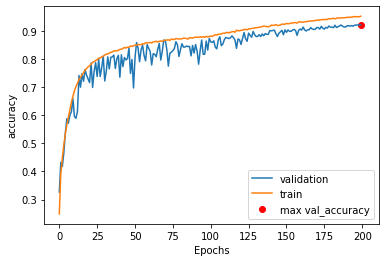

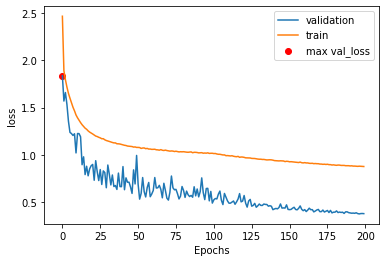

0.0788 in 64.0 min



0.0788000226020813

In [9]:
print("Training during 15 epochs. CLR Schedule")

fitness_cnn.cosine_decay = False

print("ResNet20")
fitness_cnn.calc(resnet20, test=True)

Training during 15 epochs. CLR Schedule
ResNet20
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________

Epoch 1/15
312/312 [==============================] - 19s 60ms/step - loss: 2.1682 - accuracy: 0.3887 - val_loss: 1.8280 - val_accuracy: 0.4092
Epoch 2/15
312/312 [==============================] - 13s 43ms/step - loss: 1.6387 - accuracy: 0.5560 - val_loss: 3.1917 - val_accuracy: 0.3181
Epoch 3/15
312/312 [==============================] - 13s 43ms/step - loss: 1.5709 - accuracy: 0.6080 - val_loss: 3.1929 - val_accuracy: 0.2669
Epoch 4/15
312/312 [==============================] - 13s 43ms/step - loss: 1.5801 - accuracy: 0.6237 - val_loss: 2.3615 - val_accuracy: 0.3311
Epoch 5/15
312/312 [==============================] - 13s 42ms/step - loss: 1.5966 - accuracy: 0.6319 - val_loss: 2.5650 - val_accuracy: 0.3323
Epoch 6/15
312/312 [==============================] - 13s 42ms/step - loss: 1.6438 - accuracy: 0.6241 - val_loss: 3.6810 - val_accuracy: 0.3241
Epoch 7/15
312/312 [==============================] - 13s 41ms/step - loss: 1.6613 - accuracy: 0.6189 - val_loss: 2.8640 - val_accuracy:

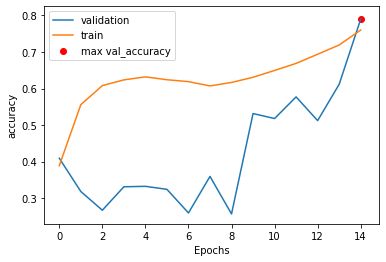

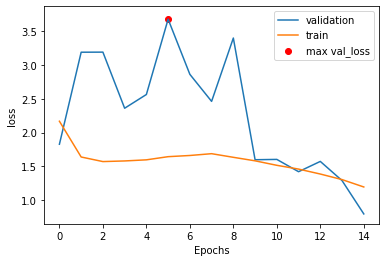

0.2102 in 3.6 min

ResNet20 like
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 17)   2465        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 17)   68          conv2d_2[0][0]                   
_____________________________

Epoch 1/15
312/312 [==============================] - 19s 61ms/step - loss: 1.8242 - accuracy: 0.3812 - val_loss: 5.4715 - val_accuracy: 0.1601
Epoch 2/15
312/312 [==============================] - 13s 42ms/step - loss: 1.4908 - accuracy: 0.5501 - val_loss: 1.5426 - val_accuracy: 0.4959
Epoch 3/15
312/312 [==============================] - 14s 43ms/step - loss: 1.3684 - accuracy: 0.6125 - val_loss: 1.6830 - val_accuracy: 0.5003
Epoch 4/15
312/312 [==============================] - 14s 43ms/step - loss: 1.2946 - accuracy: 0.6505 - val_loss: 1.6652 - val_accuracy: 0.5255
Epoch 5/15
312/312 [==============================] - 14s 44ms/step - loss: 1.2446 - accuracy: 0.6744 - val_loss: 1.6429 - val_accuracy: 0.4564
Epoch 6/15
312/312 [==============================] - 14s 44ms/step - loss: 1.2189 - accuracy: 0.6887 - val_loss: 1.1356 - val_accuracy: 0.5980
Epoch 7/15
312/312 [==============================] - 14s 44ms/step - loss: 1.1892 - accuracy: 0.7064 - val_loss: 1.1241 - val_accuracy:

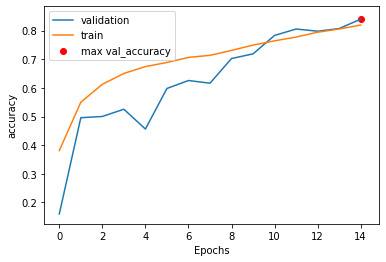

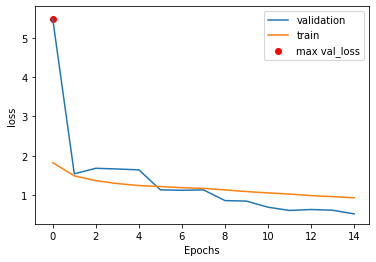

0.1602 in 3.7 min

DenseNet
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 3)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   672         activation_1[0][0]               
__________________________________

Epoch 1/15
312/312 [==============================] - 213s 681ms/step - loss: 1.8992 - accuracy: 0.3487 - val_loss: 3.8493 - val_accuracy: 0.2099
Epoch 2/15
312/312 [==============================] - 151s 484ms/step - loss: 1.5871 - accuracy: 0.5058 - val_loss: 4.4637 - val_accuracy: 0.3187
Epoch 3/15
312/312 [==============================] - 153s 492ms/step - loss: 1.4409 - accuracy: 0.5828 - val_loss: 2.6173 - val_accuracy: 0.3118
Epoch 4/15
312/312 [==============================] - 155s 496ms/step - loss: 1.3907 - accuracy: 0.6070 - val_loss: 3.8922 - val_accuracy: 0.3603
Epoch 5/15
312/312 [==============================] - 153s 492ms/step - loss: 1.3783 - accuracy: 0.6191 - val_loss: 2.7554 - val_accuracy: 0.3642
Epoch 6/15
312/312 [==============================] - 153s 491ms/step - loss: 1.3699 - accuracy: 0.6278 - val_loss: 4.8846 - val_accuracy: 0.2665
Epoch 7/15
312/312 [==============================] - 153s 491ms/step - loss: 1.3918 - accuracy: 0.6258 - val_loss: 3.0674 -

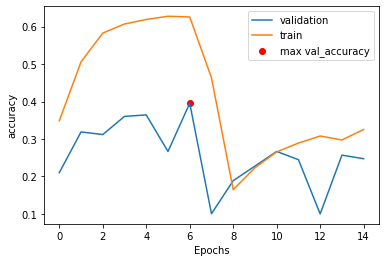

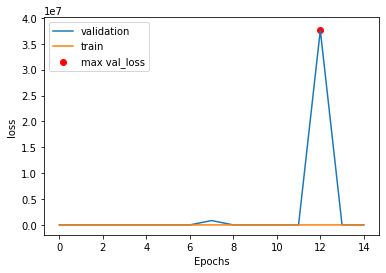

0.6045 in 42.2 min



0.6044999957084656

In [8]:
print("Training during 15 epochs. CLR Schedule")

fitness_cnn.cosine_decay = False

print("ResNet20")
fitness_cnn.calc(resnet20)

print("ResNet20 like")
fitness_cnn.calc(resnet_Chr)

print("DenseNet")
fitness_cnn.calc(densenet)

In [13]:
print("Training during 200 epochs. CLR Schedule")

fitness_cnn.cosine_decay = False

print("ResNet20 like")
fitness_cnn.calc(resnet_Chr, precise_mode=True)

print("ResNet20")
fitness_cnn.calc(resnet20, precise_mode=True)

Training during 200 epochs. CLR Schedule
ResNet20 like
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 17)   2465        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 17)   68          conv2d_2[0][0]                   
_______

Epoch 1/200
312/312 [==============================] - 16s 52ms/step - loss: 2.1767 - accuracy: 0.2624 - val_loss: 2.9937 - val_accuracy: 0.1236
Epoch 2/200
312/312 [==============================] - 12s 39ms/step - loss: 1.8096 - accuracy: 0.4464 - val_loss: 1.6438 - val_accuracy: 0.4463
Epoch 3/200
312/312 [==============================] - 13s 40ms/step - loss: 1.6766 - accuracy: 0.5116 - val_loss: 1.5379 - val_accuracy: 0.4836
Epoch 4/200
312/312 [==============================] - 12s 39ms/step - loss: 1.5813 - accuracy: 0.5596 - val_loss: 1.4119 - val_accuracy: 0.5549
Epoch 5/200
312/312 [==============================] - 12s 39ms/step - loss: 1.4993 - accuracy: 0.5996 - val_loss: 1.3278 - val_accuracy: 0.5689
Epoch 6/200
312/312 [==============================] - 12s 39ms/step - loss: 1.4447 - accuracy: 0.6265 - val_loss: 1.4046 - val_accuracy: 0.5565
Epoch 7/200
312/312 [==============================] - 13s 40ms/step - loss: 1.3864 - accuracy: 0.6552 - val_loss: 1.1535 - val_ac

312/312 [==============================] - 12s 39ms/step - loss: 1.1891 - accuracy: 0.7969 - val_loss: 0.8698 - val_accuracy: 0.7909
Epoch 114/200
312/312 [==============================] - 12s 38ms/step - loss: 1.1820 - accuracy: 0.7987 - val_loss: 0.9141 - val_accuracy: 0.7835
Epoch 115/200
312/312 [==============================] - 12s 39ms/step - loss: 1.1829 - accuracy: 0.7994 - val_loss: 0.9193 - val_accuracy: 0.7805
Epoch 116/200
312/312 [==============================] - 12s 39ms/step - loss: 1.1752 - accuracy: 0.8014 - val_loss: 1.2604 - val_accuracy: 0.6571
Epoch 117/200
312/312 [==============================] - 12s 38ms/step - loss: 1.1678 - accuracy: 0.8042 - val_loss: 0.9156 - val_accuracy: 0.7715
Epoch 118/200
312/312 [==============================] - 12s 38ms/step - loss: 1.1709 - accuracy: 0.8004 - val_loss: 0.9492 - val_accuracy: 0.7510
Epoch 119/200
312/312 [==============================] - 12s 38ms/step - loss: 1.1640 - accuracy: 0.8028 - val_loss: 0.8724 - val_ac

KeyboardInterrupt: 

In [ ]:
print("Training during 200 epochs. Step Schedule")

fitness_cnn.cosine_decay = True

print("ResNet20 like")
fitness_cnn.calc(resnet_Chr, precise_mode=True)

print("ResNet20")
fitness_cnn.calc(resnet20, precise_mode=True)



In [ ]:
print("Training during 200 epochs. CLR Schedule Test")

cosine_dec = False
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

print("ResNet20")
fitness_cnn.calc(resnet20, test=True)

fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

print("ResNet20 like")
fitness_cnn.calc(resnet_Chr, test=True)

In [ ]:
print("Training during 200 epochs. Step Schedule Test")

cosine_decay = True
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

print("ResNet20")
fitness_cnn.calc(resnet20, test=True)

fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

print("ResNet20 like")
fitness_cnn.calc(resnet_Chr, test=True)

In [ ]:
points = [(0,0), (80,0), (30,90), (0, 50)]
import matplotlib.pyplot as plt
import numpy as np
import cv2

im = np.zeros((100, 100))
aux_points = points
aux_points.append(points[0])
for i in range(len(aux_points) - 1):
    p = aux_points[i]
    q = aux_points[i + 1]
    im = cv2.line(im, p, q, (255, 0 , 0))
    
def estimate_area(poligon):
    minx, miny = poligon[0]
    maxx, maxy = poligon[0]
    for p in poligon:
        minx = min(minx, p[0])
        miny = min(miny, p[1])
        maxx = max(maxx, p[0])
        maxy = max(maxy, p[1])
        
    return (maxx - minx) * (maxy - miny)

print(estimate_area(points))
print(80 * 90 / 2)
        

In [ ]:
plt.imshow(im); plt.show()

Training during 15 epochs. CLR Schedule
ResNet20
Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________

Epoch 1/15
312/312 [==============================] - 17s 53ms/step - loss: 2.0216 - accuracy: 0.3482 - val_loss: 1.7272 - val_accuracy: 0.3642
Epoch 2/15
312/312 [==============================] - 12s 39ms/step - loss: 1.5500 - accuracy: 0.5215 - val_loss: 2.0913 - val_accuracy: 0.3854
Epoch 3/15
312/312 [==============================] - 12s 39ms/step - loss: 1.3845 - accuracy: 0.6059 - val_loss: 1.8742 - val_accuracy: 0.4533
Epoch 4/15
312/312 [==============================] - 12s 39ms/step - loss: 1.2611 - accuracy: 0.6674 - val_loss: 1.4283 - val_accuracy: 0.5475
Epoch 5/15
312/312 [==============================] - 12s 39ms/step - loss: 1.1906 - accuracy: 0.7003 - val_loss: 1.1648 - val_accuracy: 0.6056
Epoch 6/15
312/312 [==============================] - 12s 39ms/step - loss: 1.1315 - accuracy: 0.7281 - val_loss: 0.9014 - val_accuracy: 0.6975
Epoch 7/15
312/312 [==============================] - 12s 39ms/step - loss: 1.0952 - accuracy: 0.7458 - val_loss: 1.1977 - val_accuracy:

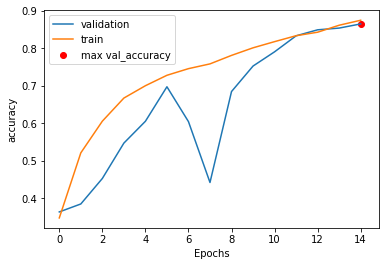

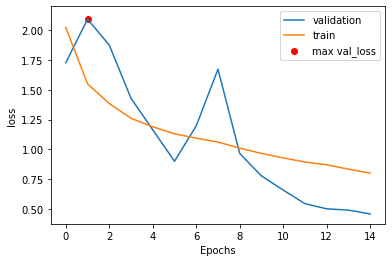

0.1351 in 3.3 min



0.13510000705718994

In [44]:
print("Training during 15 epochs. CLR Schedule")
resnet20 = ResNet20(reg=False, init=True, drop=False)

fitness_cnn.cosine_decay = False

print("ResNet20")
fitness_cnn.calc(resnet20)


In [ ]:
x = Conv2D(self.INITIAL_FILTERS, 3, activation='relu', padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(inp)
        x = BatchNormalization()()